Načítám efemeridy DE421...
Počítám Earthshine pro 3/2025 v Praze...


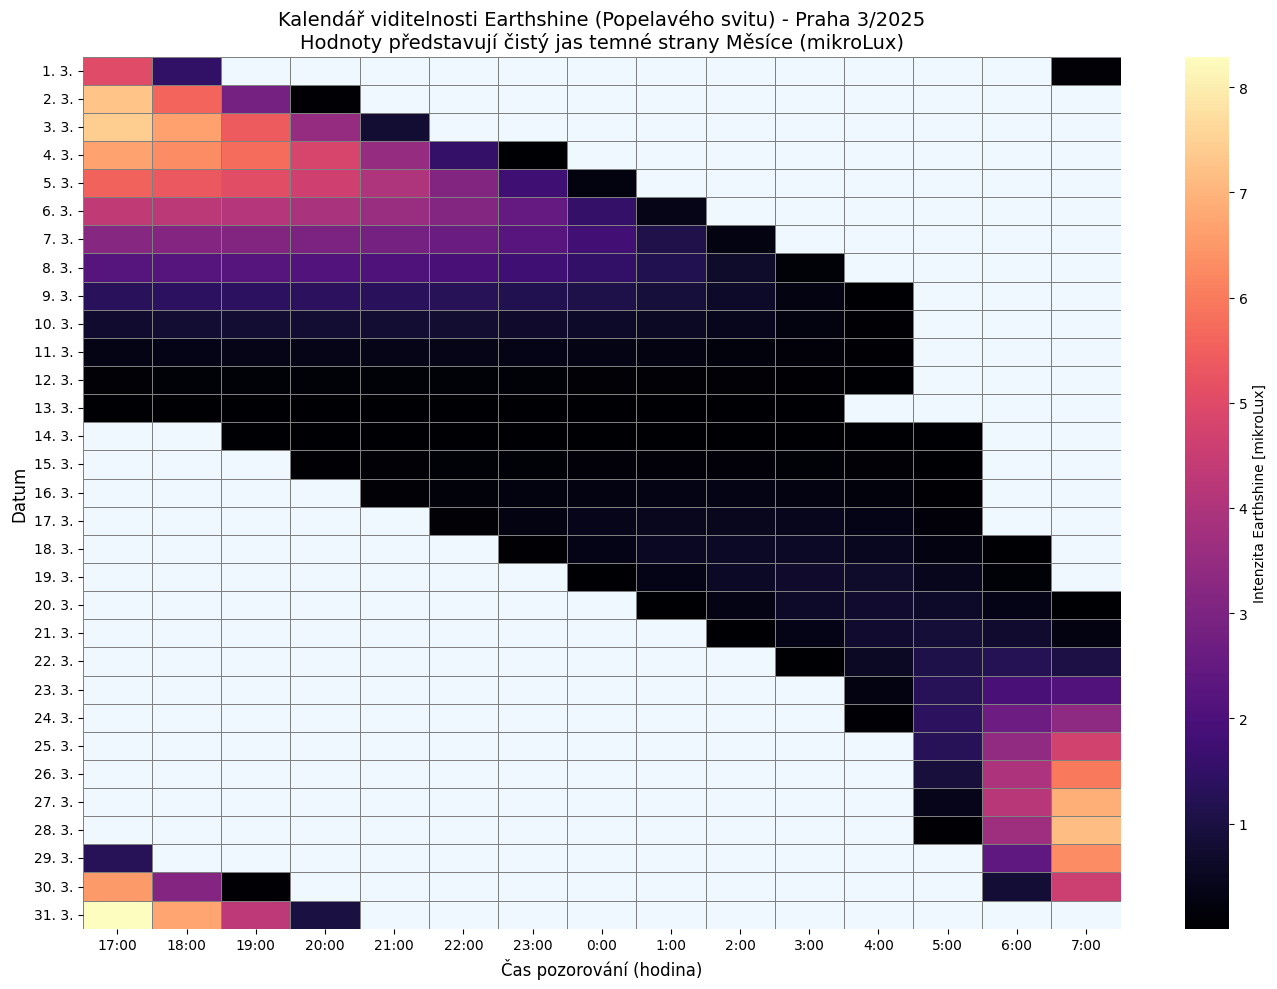


LEGENDA:
- Tmavé/Černé barvy: Měsíc je sice nad obzorem, ale Earthshine je slabý (blízko Úplňku).
- Světlé/Žluté barvy: Earthshine je nejsilnější (kolem Novu).
- Modré/Prázdné (AliceBlue): Měsíc je pod obzorem.


In [5]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
import calendar

# Přidání cesty k src
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

from illumination_model.astrometry import AstrometryEngine, ObserverLocation
from illumination_model.sources.moon import MoonModel
from illumination_model.atmosphere import AtmosphereModel

# --- NASTAVENÍ PARAMETRŮ ---
YEAR = 2025
MONTH = 3  # Březen (dobré období pro Earthshine večer)
LOCATION = {
    'lat': 50.0755,  # Praha
    'lon': 14.4378,
    'elev': 200
}
TURBIDITY = 3.0  # Standardní čistá obloha

# --- INICIALIZACE MODELŮ ---
engine = AstrometryEngine()
observer = ObserverLocation(LOCATION['lat'], LOCATION['lon'], LOCATION['elev'])
moon_model = MoonModel(engine)
atmos_model = AtmosphereModel()

def calculate_pure_earthshine_surface(t, obs_loc):
    """
    Vypočte intenzitu POUZE popelavého svitu (Earthshine) dopadajícího na zem.
    Ignoruje přímé sluneční světlo odražené Měsícem (osvětlený srpek).
    """
    # 1. Poloha Měsíce
    alt, az, dist_km = engine.calculate_moon_position(obs_loc, t)
    
    # Pokud je pod obzorem, nevidíme nic
    if alt <= 0:
        return 0.0
    
    # 2. Fázový úhel
    phi = moon_model.calculate_phase_angle(t)
    
    # 3. Výpočet Earthshine nad atmosférou (Exo-atmospheric)
    # Využijeme interní metody MoonModelu, ale jen pro složku Earthshine
    
    # a) Intenzita Earthshine dopadající na Měsíc (Lux)
    # Použijeme metodu pro W/m2 a převedeme na Lux
    e_earthshine_wm2 = moon_model._calculate_earthshine_wm2(phi)
    conversion_ratio = moon_model.SOLAR_ILLUMINANCE_LUX / moon_model.SOLAR_IRRADIANCE_WM2
    e_earthshine_on_moon_lux = e_earthshine_wm2 * conversion_ratio
    
    # b) Odraz od Měsíce směrem k Zemi (Lambert + Geometrie)
    # E_surface = Lambert * Albedo * Geometry * E_incoming
    geometry_factor = (moon_model.MOON_RADIUS_KM / dist_km)**2
    
    # Earthshine nepodléhá opozičnímu efektu (nastává při Novu, ne Úplňku)
    exo_earthshine_lux = (
        moon_model.LAMBERT_SPHERE_FACTOR * moon_model.MOON_ALBEDO * geometry_factor * e_earthshine_on_moon_lux
    )
    
    # 4. Průchod atmosférou
    transmittance = atmos_model.get_transmittance(alt, TURBIDITY)
    
    # 5. Projekce na povrch (neřešíme náklon plochy, zajímá nás intenzita "ve vzduchu" / kolmo na paprsek
    # pro vizuální vjem jasu Měsíce, ne osvětlení stolu). 
    # Ale aby to bylo konzistentní s luxmetrem, použijeme sin(alt).
    # Pro vizuální vjem (jas disku) bychom sin(alt) vynechali, ale zde počítáme Illuminance.
    
    surface_earthshine = exo_earthshine_lux * transmittance # * np.sin(np.radians(alt))
    
    return surface_earthshine

# --- GENERUJEME DATA PRO KALENDÁŘ ---

# Časová osa: 17:00 až 07:00 (+1 den)
hours_sequence = [17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7]
days_in_month = calendar.monthrange(YEAR, MONTH)[1]

data_matrix = []
days_labels = []

print(f"Počítám Earthshine pro {MONTH}/{YEAR} v Praze...")

for day in range(1, days_in_month + 1):
    day_row = []
    days_labels.append(f"{day}. {MONTH}.")
    
    for hour in hours_sequence:
        # Určení správného data a času
        # Pokud je hodina < 12, znamená to už následující den ráno
        if hour < 12:
            calc_day = day + 1
            # Ošetření přechodu měsíce
            if calc_day > days_in_month:
                # Pro jednoduchost vizualizace konce měsíce:
                # buď přeskočíme, nebo vezmeme 1. den dalšího měsíce.
                # Zde nastavíme NaN (mimo kalendář)
                day_row.append(np.nan)
                continue
            
            calc_date = datetime(YEAR, MONTH, calc_day, hour, 0)
        else:
            calc_date = datetime(YEAR, MONTH, day, hour, 0)
            
        # Převod na Skyfield Time

        # --- OPRAVENÝ ŘÁDEK ZDE ---
        # Používáme timezone.utc
        ts = engine.ts
        t = ts.from_datetime(calc_date.replace(tzinfo=timezone.utc))
        # Výpočet
        lux = calculate_pure_earthshine_surface(t, observer)
        
        # Logaritmická úprava pro lepší vizualizaci (oko vnímá logaritmicky)
        # Abychom se vyhnuli log(0), přičteme malé epsilon nebo nahradíme 0 -> NaN
        if lux <= 1e-9:
            val = 0 # Pod obzorem nebo absolutní tma
        else:
            val = lux * 1_000_000 # Převedeme na mikroLuxy pro čitelnější čísla
            
        day_row.append(val)
    
    data_matrix.append(day_row)

# --- VIZUALIZACE ---

# Příprava DataFrame
df = pd.DataFrame(data_matrix, columns=[f"{h}:00" for h in hours_sequence], index=days_labels)

plt.figure(figsize=(14, 10))

# Vytvoření masky pro hodnoty 0 (Měsíc pod obzorem), aby byly šedé/bílé
mask = (df == 0) | (df.isna())

# Heatmapa
# Používáme colormap 'magma' (černá -> červená -> žlutá), což evokuje svit
ax = sns.heatmap(df, 
                 mask=mask,
                 cmap="magma", 
                 annot=False, # Změnit na True, pokud chcete vidět čísla
                 fmt=".1f",
                 cbar_kws={'label': 'Intenzita Earthshine [mikroLux]'},
                 linewidths=.5, 
                 linecolor='gray')

# Nastavení pozadí pro maskované hodnoty (pod obzorem)
ax.set_facecolor("aliceblue")

plt.title(f"Kalendář viditelnosti Earthshine (Popelavého svitu) - Praha {MONTH}/{YEAR}\n"
          f"Hodnoty představují čistý jas temné strany Měsíce (mikroLux)", fontsize=14)
plt.xlabel("Čas pozorování (hodina)", fontsize=12)
plt.ylabel("Datum", fontsize=12)

# Vylepšení popisků
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# --- VYSVĚTLIVKY ---
print("\nLEGENDA:")
print("- Tmavé/Černé barvy: Měsíc je sice nad obzorem, ale Earthshine je slabý (blízko Úplňku).")
print("- Světlé/Žluté barvy: Earthshine je nejsilnější (kolem Novu).")
print("- Modré/Prázdné (AliceBlue): Měsíc je pod obzorem.")